In [1]:
import numpy as np
from numba import njit
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal

from hyppo.tools import multimodal_independence, indep_sim
from hyppo.ksample._utils import k_sample_transform
from tqdm import tqdm

import sys
import os
import multiprocessing as mp
from joblib import Parallel, delayed

C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def test_stat_helper(est_nodes, eval_nodes, est_classes, class_counts, K, kappa=3, base=2):
    """
    est_nodes : list
        Leaf indices used for voting
    eval_nodes : list
        Leaf indices in which a sample from the density subsample falls
    est_classes : list
        Voter class labels in est_node leaves
    """
    for i in range(len(est_nodes)):
        class_counts[est_nodes[i], est_classes[i]] += 1

    # Total number of estimation points in each leaf.
    row_sums = class_counts.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid divide by zero.
    class_probs = class_counts / row_sums[:, None]

    # Make the nodes that have no estimation indices uniform.
    # This includes non-leaf nodes, but tha t will not affect the estimate.
    class_probs[np.argwhere(class_probs.sum(axis=1) == 0)] = [1 / K]*K
    # Apply finite sample correction and renormalize.
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / \
            (kappa*class_counts.sum(axis=1)[elem[0]])
    row_sums = class_probs.sum(axis=1)
    class_probs = class_probs / row_sums[:, None]

    # Place evaluation points in their corresponding leaf node.
    # Store evaluation posterior in a num_eval-by-num_class matrix.
    eval_class_probs = class_probs[eval_nodes]
    eval_entropies = [entropy(posterior, base=base)
                      for posterior in eval_class_probs]
    return np.mean(eval_entropies)


In [3]:
def uf(X, y, n_estimators=300, max_samples=.4, base=2, kappa=3, reps=100, n_jobs=None):
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(),
                              n_estimators=n_estimators,
                              max_samples=max_samples,
                              n_jobs=n_jobs,
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)

    cond_entropy = 0
    final_null_dist = [0] * 100

    tree_est_nodes = []
    tree_eval_nodes = []
    tree_unsampled_indices = []

    # Get real test statistics
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0, n), sampled_indices)
        np.random.shuffle(unsampled_indices)
        tree_unsampled_indices.append(unsampled_indices)

        # Randomly split the rest into voting and evaluation.
        vote_indices = unsampled_indices[:len(unsampled_indices)//2]
        eval_indices = unsampled_indices[len(unsampled_indices)//2:]

        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        est_nodes = tree.apply(X[vote_indices])
        tree_est_nodes.append(est_nodes)
        eval_nodes = tree.apply(X[eval_indices])
        tree_eval_nodes.append(eval_nodes)

        cond_entropy += test_stat_helper(
            est_nodes, eval_nodes, y[vote_indices], class_counts, K)

    # Generate null dist
    for j in range(reps):
        for tree, unsampled_indices, est_nodes, eval_nodes in zip(
            model, tree_unsampled_indices, tree_est_nodes, tree_eval_nodes
        ):
            node_counts = tree.tree_.n_node_samples
            class_counts = np.zeros((len(node_counts), K))
            y_vote = y[unsampled_indices]
            np.random.shuffle(y_vote)
            final_null_dist[j] += test_stat_helper(
                est_nodes, eval_nodes, y_vote[:len(unsampled_indices)//2], class_counts, K)

    # note: shuffling y doesn't change these outputs
    new_final_null_dist = [entropy([np.mean(
        y), 1 - np.mean(y)], base=2) - val / n_estimators for val in final_null_dist]

    final_stat = entropy([np.mean(y), 1 - np.mean(y)],
                         base=2) - cond_entropy / n_estimators
    return final_stat, new_final_null_dist

In [4]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 20
SAMP_SIZES = range(10, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 20

SIMULATIONS = [
    # "linear": "Linear",
    # "multimodal_independence": "Independence"
    # linear,
    multimodal_independence
]

In [5]:
def estimate_power(sim, n_jobs=None):
    samp_size_dict = dict()
    samp_size_dict['sample_sizes'] = SAMP_SIZES
    samp_size_dict['n_power_reps'] = POWER_REPS
    power = []
    for n_samples in SAMP_SIZES:
        pvalues = []
        samp_size_dict[n_samples] = {'stats': [], 'null_dists': []}
        for p in tqdm(range(POWER_REPS)):
            np.random.seed(None)
            matrix1, matrix2 = multimodal_independence(n_samples, 2)
            x, y = k_sample_transform([matrix1, matrix2])
            stat, null_dist = uf(x, y.ravel(), n_jobs=n_jobs)
            samp_size_dict[n_samples]['stats'].append(stat)
            samp_size_dict[n_samples]['null_dists'].append(null_dist)
            pvalue = np.mean(np.asarray(null_dist) >= stat)
            print("P-value: " + str(pvalue))
            print(f'Test stat: {stat}')
            print(f'Null dist: {null_dist[:5]}')
            pvalues.append(pvalue)

        power.append(np.mean(np.asarray(pvalues) <= 0.05))
        #power.append((pvalues >= 0.05).sum() / POWER_REPS)

    with open('multimodal_independence_power_reps.pkl', 'wb') as handle:
        pickle.dump(samp_size_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    np.savetxt('multimodal_independence_power.csv',
               power, delimiter=',')

    return power

In [6]:
estimate_power(SIMULATIONS[0], n_jobs=4)

  5%|████▏                                                                              | 1/20 [00:34<10:49, 34.18s/it]

P-value: 0.12
Test stat: 0.15455264884006137
Null dist: [0.13462583494242064, 0.15263962162810152, 0.1510762019942793, 0.14706499965001507, 0.14734357777660378]


 10%|████████▎                                                                          | 2/20 [01:12<10:39, 35.53s/it]

P-value: 0.03
Test stat: 0.1648746551511383
Null dist: [0.13533402031125163, 0.16032598902437833, 0.14393199718241267, 0.16552639527216817, 0.14681943069730063]


 15%|████████████▍                                                                      | 3/20 [01:51<10:17, 36.33s/it]

P-value: 0.54
Test stat: 0.14816434455044047
Null dist: [0.15240929675281445, 0.15856301147398477, 0.1472534287598377, 0.15145762364766313, 0.15372625329798495]


 20%|████████████████▌                                                                  | 4/20 [02:30<09:55, 37.23s/it]

P-value: 0.78
Test stat: 0.14303051355350382
Null dist: [0.14371006919037876, 0.14914106013004258, 0.14923538322201024, 0.1395928930480369, 0.1511702444090124]


 25%|████████████████████▊                                                              | 5/20 [03:02<08:55, 35.71s/it]

P-value: 0.99
Test stat: 0.13800940422647423
Null dist: [0.14728224404687418, 0.157427893113945, 0.141594644511308, 0.15225232335522432, 0.1549659128172719]


 30%|████████████████████████▉                                                          | 6/20 [03:32<07:55, 33.94s/it]

P-value: 0.81
Test stat: 0.14625391417158218
Null dist: [0.1533386425087353, 0.1453170705319049, 0.15018279834958925, 0.14590223503404143, 0.14969789079115392]


 35%|█████████████████████████████                                                      | 7/20 [04:02<07:04, 32.66s/it]

P-value: 0.67
Test stat: 0.14344424605637185
Null dist: [0.14945963971472798, 0.13897166407041117, 0.15069371028422007, 0.14654620743114488, 0.1334499869128486]


 40%|█████████████████████████████████▏                                                 | 8/20 [04:37<06:42, 33.54s/it]

P-value: 0.3
Test stat: 0.15288125344243064
Null dist: [0.15488349682829772, 0.1499696513242842, 0.15362895013084665, 0.14670126986244258, 0.14195795708975123]


 45%|█████████████████████████████████████▎                                             | 9/20 [05:11<06:09, 33.58s/it]

P-value: 0.71
Test stat: 0.1430476016962683
Null dist: [0.14485307854016094, 0.14794985393520899, 0.14904644846627002, 0.14913890567416832, 0.13649867421030426]


 50%|█████████████████████████████████████████                                         | 10/20 [05:40<05:22, 32.24s/it]

P-value: 0.82
Test stat: 0.14374564369503318
Null dist: [0.15452718574965563, 0.15413673252678073, 0.14449214880620198, 0.1507483917324257, 0.14349981306099324]


 55%|█████████████████████████████████████████████                                     | 11/20 [06:09<04:42, 31.40s/it]

P-value: 0.0
Test stat: 0.1839973540413179
Null dist: [0.16030230534921708, 0.16308270893136656, 0.15731030286666514, 0.15863690133166886, 0.14717573446457644]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [06:39<04:06, 30.87s/it]

P-value: 0.79
Test stat: 0.13914699688081555
Null dist: [0.13809818184615708, 0.15257172145497533, 0.15010436489687318, 0.15691301038332484, 0.15149612523073686]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [07:10<03:36, 30.92s/it]

P-value: 0.34
Test stat: 0.15011146382738672
Null dist: [0.14044575147191074, 0.15747399397085038, 0.14280429267301353, 0.1459825004182852, 0.1486770584655963]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [07:40<03:03, 30.51s/it]

P-value: 0.23
Test stat: 0.15224176719294158
Null dist: [0.14823449381117537, 0.1547112432838088, 0.1523318837210943, 0.14338762795122728, 0.13384416993274617]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [08:11<02:33, 30.69s/it]

P-value: 0.0
Test stat: 0.18720880507647053
Null dist: [0.15138744372747648, 0.16142029700837635, 0.15244789543858406, 0.157635151399103, 0.16067220968947826]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [09:13<02:41, 40.30s/it]

P-value: 0.61
Test stat: 0.15266884858835428
Null dist: [0.16053060249378504, 0.1470976070488742, 0.15554032802240458, 0.15226234232762414, 0.15947262961143815]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [10:04<02:09, 43.29s/it]

P-value: 0.03
Test stat: 0.16011013772366278
Null dist: [0.14859996389786356, 0.15083158499441818, 0.15570972378109327, 0.1417481427648848, 0.14802694438542607]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [10:43<01:24, 42.03s/it]

P-value: 0.19
Test stat: 0.158441539755509
Null dist: [0.14223996431790242, 0.14505658392471954, 0.15443242193185502, 0.148025107520791, 0.15242488770259488]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [11:22<00:41, 41.09s/it]

P-value: 0.02
Test stat: 0.16362321948598846
Null dist: [0.15211145024468808, 0.14635265806231457, 0.1551199073072913, 0.14519452244171438, 0.14140427836946212]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

P-value: 0.17
Test stat: 0.1555186485970973
Null dist: [0.14331924895131443, 0.14423900651460841, 0.14250404819025841, 0.15490015967298254, 0.14589219851964463]


  5%|████▏                                                                              | 1/20 [00:56<18:00, 56.89s/it]

P-value: 0.87
Test stat: 0.1391148089310572
Null dist: [0.14398367063398576, 0.14405757639677386, 0.1407696626830337, 0.14048482550331431, 0.14041111695134612]


 10%|████████▎                                                                          | 2/20 [01:49<16:41, 55.66s/it]

P-value: 0.83
Test stat: 0.1370560847002632
Null dist: [0.1436640866241945, 0.14114150323511432, 0.139844045071031, 0.14228006614525235, 0.13655963098669166]


 15%|████████████▍                                                                      | 3/20 [02:54<16:32, 58.36s/it]

P-value: 0.2
Test stat: 0.14587983388008507
Null dist: [0.14676119438441726, 0.13368314885402244, 0.14518302265045047, 0.1439290965096296, 0.13532316083564921]


 20%|████████████████▌                                                                  | 4/20 [04:17<17:32, 65.81s/it]

P-value: 0.99
Test stat: 0.13779084340560455
Null dist: [0.1458417916105067, 0.1498584627062256, 0.14791143832118414, 0.14631371597575893, 0.14604357017850322]


 25%|████████████████████▊                                                              | 5/20 [05:02<14:52, 59.51s/it]

P-value: 0.99
Test stat: 0.13688204671481263
Null dist: [0.14989468868226974, 0.148035230992268, 0.14695661806815585, 0.14171169579896947, 0.1498210753635183]


 30%|████████████████████████▉                                                          | 6/20 [05:46<12:47, 54.80s/it]

P-value: 0.88
Test stat: 0.13711348274128943
Null dist: [0.1382109429086188, 0.14232691209670045, 0.14637657566564366, 0.1360192542954889, 0.14772367973213596]


 35%|█████████████████████████████                                                      | 7/20 [06:42<11:57, 55.16s/it]

P-value: 0.9
Test stat: 0.13628192017784047
Null dist: [0.14218448631200786, 0.1428062577467354, 0.13725271111210158, 0.1328826398827353, 0.13632237924526525]


 40%|█████████████████████████████████▏                                                 | 8/20 [07:28<10:31, 52.65s/it]

P-value: 0.97
Test stat: 0.13004209708133863
Null dist: [0.14045016784373998, 0.13364412941455006, 0.1372165760850642, 0.1462109231886095, 0.14280810146750433]


 45%|█████████████████████████████████████▎                                             | 9/20 [08:21<09:38, 52.59s/it]

P-value: 0.73
Test stat: 0.13620165840751386
Null dist: [0.14172378071801628, 0.13771013695319367, 0.13986036008587743, 0.137475964226921, 0.135226230774807]


 50%|█████████████████████████████████████████                                         | 10/20 [09:39<10:01, 60.18s/it]

P-value: 0.13
Test stat: 0.14364371908840878
Null dist: [0.14340088555982944, 0.13903307471852178, 0.13954349658319454, 0.13664684925688297, 0.1366062718537605]


 55%|█████████████████████████████████████████████                                     | 11/20 [10:36<08:54, 59.39s/it]

P-value: 0.22
Test stat: 0.14601780727849922
Null dist: [0.14868940940278108, 0.14599179992638256, 0.14736838289969534, 0.13741244545374987, 0.13649949314088894]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [11:26<07:32, 56.59s/it]

P-value: 0.18
Test stat: 0.15102814058168657
Null dist: [0.14458871184921884, 0.1539070909797401, 0.15002013025134175, 0.15231253881191953, 0.1544644696170424]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [12:23<06:35, 56.55s/it]

P-value: 0.95
Test stat: 0.13533290092307537
Null dist: [0.1501300485698338, 0.14341463668775356, 0.14138179318369848, 0.14049396581907692, 0.1403156110860857]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [13:08<05:18, 53.04s/it]

P-value: 0.0
Test stat: 0.15549400600330932
Null dist: [0.13331884924792325, 0.12817193258561133, 0.13566118562115947, 0.14500333453686776, 0.14230998397594286]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [13:52<04:12, 50.44s/it]

P-value: 0.25
Test stat: 0.14106469921267284
Null dist: [0.13316289305082096, 0.1419421721967441, 0.1407127239558793, 0.13211327435533138, 0.13643002681708116]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [14:38<03:16, 49.12s/it]

P-value: 0.58
Test stat: 0.14292736168976716
Null dist: [0.14339280080045091, 0.14609027626018434, 0.1394740101195867, 0.1380722662649102, 0.13535604588296812]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [15:24<02:24, 48.11s/it]

P-value: 0.09
Test stat: 0.143277104910155
Null dist: [0.1371885505247824, 0.1368890564721401, 0.13343706719795323, 0.13466398952414882, 0.13527339989171494]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [16:13<01:36, 48.49s/it]

P-value: 0.09
Test stat: 0.15597271673293212
Null dist: [0.15076505915101857, 0.15336067902780737, 0.14269826984502154, 0.1511165804712402, 0.15017124123413927]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [17:21<00:54, 54.36s/it]

P-value: 0.16
Test stat: 0.14329929364938965
Null dist: [0.13952033142792208, 0.1333105204407513, 0.13654818623047016, 0.13845463529451385, 0.13775753040880434]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

P-value: 0.88
Test stat: 0.13665040807604445
Null dist: [0.13963711725028283, 0.14200354014339245, 0.14961619356838263, 0.14279467334721463, 0.13437263705835178]


  5%|████▏                                                                              | 1/20 [00:58<18:37, 58.82s/it]

P-value: 1.0
Test stat: 0.13068539595153972
Null dist: [0.14006383209406204, 0.14322056950518436, 0.14118398545019673, 0.1402802355976066, 0.14382366416642356]


 10%|████████▎                                                                          | 2/20 [02:04<18:13, 60.75s/it]

P-value: 0.01
Test stat: 0.14667415453138588
Null dist: [0.13530675009877347, 0.13716659091724281, 0.13799272278428132, 0.1366467652702903, 0.13642333102548354]


 15%|████████████▍                                                                      | 3/20 [03:07<17:27, 61.61s/it]

P-value: 0.53
Test stat: 0.1434583626420306
Null dist: [0.1458340858015187, 0.14406626945007472, 0.14367198805506143, 0.14746081099965835, 0.14460294142237617]


 20%|████████████████▌                                                                  | 4/20 [04:33<18:21, 68.86s/it]

P-value: 0.68
Test stat: 0.14302503368916308
Null dist: [0.14118373151823604, 0.14960622736794926, 0.13975422371757518, 0.14850385943280187, 0.14205627072003912]


 25%|████████████████████▊                                                              | 5/20 [05:38<16:57, 67.82s/it]

P-value: 0.69
Test stat: 0.14258123617251117
Null dist: [0.14648169539779698, 0.14516092606206565, 0.14416366627350707, 0.14363364753571828, 0.1456497059008509]


 30%|████████████████████████▉                                                          | 6/20 [06:48<15:55, 68.27s/it]

P-value: 0.0
Test stat: 0.15764175546803683
Null dist: [0.14277670898549044, 0.1418587985976738, 0.14107397838935054, 0.1394516138235743, 0.1418365016447567]


 35%|█████████████████████████████                                                      | 7/20 [07:45<14:05, 65.05s/it]

P-value: 1.0
Test stat: 0.13556448187824177
Null dist: [0.13995523690736922, 0.1448711662611648, 0.14212350069244561, 0.1448373300463892, 0.14596318924426654]


 40%|█████████████████████████████████▏                                                 | 8/20 [08:43<12:32, 62.74s/it]

P-value: 0.94
Test stat: 0.13734069643718883
Null dist: [0.13983681883405874, 0.14589393963754294, 0.14446839575878723, 0.1527887156326192, 0.13606931342286033]


 45%|█████████████████████████████████████▎                                             | 9/20 [09:40<11:13, 61.27s/it]

P-value: 0.0
Test stat: 0.15338969349609977
Null dist: [0.140571933304513, 0.14670198162689962, 0.14645670186285897, 0.13844712365431466, 0.13556562032932562]


 50%|█████████████████████████████████████████                                         | 10/20 [10:29<09:35, 57.58s/it]

P-value: 0.18
Test stat: 0.14295697602032498
Null dist: [0.1410278449000174, 0.1344458047713336, 0.14402620305521774, 0.13835783405675595, 0.13497018577690578]


 55%|█████████████████████████████████████████████                                     | 11/20 [11:15<08:07, 54.11s/it]

P-value: 0.95
Test stat: 0.13388182792969927
Null dist: [0.13704393278521576, 0.13851779080189142, 0.14131524508571447, 0.14355665170665133, 0.1408413456088704]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [12:08<07:10, 53.78s/it]

P-value: 0.98
Test stat: 0.13287639472284996
Null dist: [0.13949569157116348, 0.14442184422858895, 0.1480693672743304, 0.1430232736685665, 0.13909269373374245]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [12:54<05:59, 51.32s/it]

P-value: 0.46
Test stat: 0.1425758998714618
Null dist: [0.14184211872880303, 0.14268149018151477, 0.14724282643612474, 0.13762444321930178, 0.14450044580918753]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [13:38<04:55, 49.19s/it]

P-value: 0.28
Test stat: 0.13957335342206156
Null dist: [0.13713600381635915, 0.13696276237510197, 0.13666468136051546, 0.1355200409477949, 0.14083313353316684]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [14:30<04:10, 50.10s/it]

P-value: 0.04
Test stat: 0.14705176728873737
Null dist: [0.13437432828382878, 0.14050917693382203, 0.14524870591705208, 0.14603790742653244, 0.14399046141936145]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [15:15<03:13, 48.37s/it]

P-value: 0.0
Test stat: 0.1604871537401945
Null dist: [0.14077864713919475, 0.13672023401510003, 0.13560562450667912, 0.1423396945733434, 0.148184368739826]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [16:01<02:22, 47.61s/it]

P-value: 0.93
Test stat: 0.1361724285514434
Null dist: [0.13842834089238576, 0.1394810750712291, 0.14206091722677272, 0.13770926166144892, 0.14140253766183564]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [16:44<01:32, 46.45s/it]

P-value: 0.99
Test stat: 0.13427589795856532
Null dist: [0.1404783526027925, 0.145995897115608, 0.14301231817104887, 0.1468451499018849, 0.1480540398175193]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [17:30<00:46, 46.17s/it]

P-value: 0.67
Test stat: 0.14040042259606078
Null dist: [0.14013679510844557, 0.145946593312951, 0.13945950972882204, 0.13464286213350474, 0.1437417344115397]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

P-value: 0.09
Test stat: 0.14402560544248877
Null dist: [0.13939469524446846, 0.1370479418785182, 0.13621562832679723, 0.1412108083761675, 0.14711055987870603]


  5%|████▏                                                                              | 1/20 [00:50<15:59, 50.48s/it]

P-value: 0.62
Test stat: 0.1375859032538551
Null dist: [0.138509111257621, 0.13809075257025993, 0.13741716904499635, 0.13749580215144097, 0.13193156330762723]


 10%|████████▎                                                                          | 2/20 [01:42<15:19, 51.08s/it]

P-value: 0.11
Test stat: 0.14255974323159537
Null dist: [0.14105551579277653, 0.1321023237241583, 0.13930423425247696, 0.14053648928507756, 0.14198498959751538]


 15%|████████████▍                                                                      | 3/20 [02:33<14:26, 50.94s/it]

P-value: 0.08
Test stat: 0.14315008658145734
Null dist: [0.14537894714005495, 0.13630847732717444, 0.13401802567760435, 0.13971039414200925, 0.13900549145050078]


 20%|████████████████▌                                                                  | 4/20 [03:25<13:37, 51.11s/it]

P-value: 0.01
Test stat: 0.14739734157961204
Null dist: [0.13946069992070553, 0.14047847502912247, 0.14282392546757094, 0.1404178707070184, 0.13774902972461023]


 25%|████████████████████▊                                                              | 5/20 [04:16<12:49, 51.27s/it]

P-value: 0.84
Test stat: 0.13652961270399222
Null dist: [0.14152621131045517, 0.13723559466646507, 0.13998605288454546, 0.14412451375965019, 0.13289072401020574]


 30%|████████████████████████▉                                                          | 6/20 [05:07<11:57, 51.22s/it]

P-value: 0.67
Test stat: 0.13822253586456934
Null dist: [0.1502837366222466, 0.14074376449702886, 0.13557522948362533, 0.1386307473986017, 0.14153117495212064]


 35%|█████████████████████████████                                                      | 7/20 [06:03<11:22, 52.50s/it]

P-value: 0.95
Test stat: 0.13458392888299475
Null dist: [0.137483100994519, 0.13979786830508167, 0.1408915503346655, 0.1392984947835132, 0.13926253881569972]


 40%|█████████████████████████████████▏                                                 | 8/20 [06:54<10:24, 52.05s/it]

P-value: 0.0
Test stat: 0.146446208927271
Null dist: [0.1327337290618128, 0.13919319343815306, 0.1321820372429604, 0.13709850625169395, 0.13532363227788646]


 45%|█████████████████████████████████████▎                                             | 9/20 [07:45<09:30, 51.90s/it]

P-value: 0.65
Test stat: 0.1375251106965646
Null dist: [0.13709088540210945, 0.13494874465004447, 0.13524081045740732, 0.14021364902749933, 0.13334658905718755]


 50%|█████████████████████████████████████████                                         | 10/20 [08:37<08:36, 51.67s/it]

P-value: 1.0
Test stat: 0.13481266793222746
Null dist: [0.14245449994151826, 0.14605214819177337, 0.14428701143755296, 0.138242552051989, 0.14385671429892355]


 55%|█████████████████████████████████████████████                                     | 11/20 [09:29<07:46, 51.84s/it]

P-value: 0.56
Test stat: 0.13902158220843075
Null dist: [0.14183929159331965, 0.1408068993199394, 0.13548420441946996, 0.14429452836218293, 0.1428677721852748]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [10:20<06:52, 51.57s/it]

P-value: 1.0
Test stat: 0.13314377301792013
Null dist: [0.13806985561077667, 0.14114034268279763, 0.13725174993976264, 0.14592016664548546, 0.1415605723031852]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [11:11<06:00, 51.46s/it]

P-value: 0.14
Test stat: 0.1446058704393316
Null dist: [0.14164899343736992, 0.14802797177517202, 0.1371743921130385, 0.14398567238052673, 0.13533540390125098]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [12:03<05:10, 51.74s/it]

P-value: 0.01
Test stat: 0.1463046742566596
Null dist: [0.13643113762540715, 0.13699961842979536, 0.1402237175242521, 0.1312144611128372, 0.1421871137626438]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [12:54<04:17, 51.41s/it]

P-value: 0.0
Test stat: 0.1521022827966999
Null dist: [0.14108294504393903, 0.14378631630273275, 0.1416596590794965, 0.13945368851519713, 0.13997507632488848]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [13:47<03:27, 51.78s/it]

P-value: 0.02
Test stat: 0.14643306724588423
Null dist: [0.1337998329373501, 0.14195904616225485, 0.1330428648579084, 0.1427249386006899, 0.13818569917032675]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [14:46<02:42, 54.04s/it]

P-value: 0.97
Test stat: 0.13554101380819839
Null dist: [0.13503218763498215, 0.14420032266194882, 0.14203753199362534, 0.1412463640377397, 0.13897638729213047]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [15:37<01:46, 53.24s/it]

P-value: 0.22
Test stat: 0.14371182842461072
Null dist: [0.14258451471329525, 0.14402381558395294, 0.14108875408503097, 0.141855485381695, 0.13941765390575034]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [16:30<00:53, 53.22s/it]

P-value: 0.95
Test stat: 0.13273201538477475
Null dist: [0.13869639981907844, 0.13900883365612193, 0.13606080759944006, 0.1369571448298479, 0.14394984066632865]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

P-value: 0.96
Test stat: 0.1384857705750665
Null dist: [0.1476020712973788, 0.14180634579961826, 0.14442965510212125, 0.1428895845921816, 0.14097321961628417]


  5%|████▏                                                                              | 1/20 [00:58<18:26, 58.26s/it]

P-value: 0.32
Test stat: 0.1417464898306675
Null dist: [0.14262522997071203, 0.14166778309450934, 0.14134120230921687, 0.1383614353349394, 0.1403274196721097]


 10%|████████▎                                                                          | 2/20 [01:55<17:22, 57.90s/it]

P-value: 0.98
Test stat: 0.13425121343983681
Null dist: [0.13908385886526697, 0.13998701798024005, 0.13653480526382356, 0.1393943459096202, 0.13754431074975026]


 15%|████████████▍                                                                      | 3/20 [02:53<16:23, 57.87s/it]

P-value: 0.72
Test stat: 0.13952893339471073
Null dist: [0.14072375686537608, 0.14322467335074707, 0.14363247362075748, 0.1379708707284366, 0.13902782556293558]


 20%|████████████████▌                                                                  | 4/20 [03:50<15:24, 57.78s/it]

P-value: 0.98
Test stat: 0.13467150271027528
Null dist: [0.1435658864172158, 0.13995886228747711, 0.13427924939521785, 0.1398069445392025, 0.1461796074538887]


 25%|████████████████████▊                                                              | 5/20 [04:50<14:35, 58.35s/it]

P-value: 0.42
Test stat: 0.14028638911467683
Null dist: [0.14381561540665033, 0.140871844392629, 0.13718927840598494, 0.1358952269071314, 0.14216575559713585]


 30%|████████████████████████▉                                                          | 6/20 [05:47<13:32, 58.04s/it]

P-value: 0.65
Test stat: 0.13467821513605294
Null dist: [0.13651218668746123, 0.13765435915058466, 0.13488911225446787, 0.13549513404704816, 0.13245244021414526]


 35%|█████████████████████████████                                                      | 7/20 [06:46<12:36, 58.22s/it]

P-value: 0.07
Test stat: 0.14404777177120331
Null dist: [0.13967316809177044, 0.13581620032370045, 0.1396492829678535, 0.14197739533280207, 0.1375051387732833]


 40%|█████████████████████████████████▏                                                 | 8/20 [07:43<11:35, 57.92s/it]

P-value: 0.63
Test stat: 0.13964401137954519
Null dist: [0.14166136005715924, 0.14565116123170319, 0.13751201296017712, 0.14001155380324193, 0.1404426431951883]


 45%|█████████████████████████████████████▎                                             | 9/20 [08:49<11:03, 60.28s/it]

P-value: 0.87
Test stat: 0.1377696490703194
Null dist: [0.14193822098326658, 0.1404005511426144, 0.14129894996641046, 0.13793382629630802, 0.13968064877764907]


 50%|█████████████████████████████████████████                                         | 10/20 [09:47<09:56, 59.68s/it]

P-value: 0.0
Test stat: 0.159428945196313
Null dist: [0.1412247330821964, 0.14522125214822645, 0.14543897197612143, 0.14498988934388157, 0.14323925644036029]


 55%|█████████████████████████████████████████████                                     | 11/20 [10:45<08:51, 59.06s/it]

P-value: 0.65
Test stat: 0.13833105744931495
Null dist: [0.14342491946514224, 0.13660000066371125, 0.14114379635708374, 0.1397718181853297, 0.1396089043750467]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [11:42<07:48, 58.58s/it]

P-value: 0.0
Test stat: 0.1493810276855322
Null dist: [0.13990602573138455, 0.14172436089166218, 0.13941718815219384, 0.1371868860908637, 0.13419314495458856]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [12:40<06:48, 58.31s/it]

P-value: 0.69
Test stat: 0.13648076131523657
Null dist: [0.13555603581698739, 0.14070266736443726, 0.13775469419594022, 0.1359044282653431, 0.14338612918761595]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [13:37<05:47, 57.99s/it]

P-value: 0.95
Test stat: 0.13636268358298198
Null dist: [0.13875682123412258, 0.14307552531321543, 0.13777560544742185, 0.1423430956719951, 0.14042566959058755]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [14:36<04:51, 58.22s/it]

P-value: 0.42
Test stat: 0.1419460127351586
Null dist: [0.14177658955367345, 0.1408736637035639, 0.13996023865094442, 0.14011935907744055, 0.14179551440449545]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [15:33<03:51, 57.99s/it]

P-value: 0.91
Test stat: 0.1361976059746074
Null dist: [0.1368546445407659, 0.13654256107131058, 0.13286431831053636, 0.13893784307502532, 0.1356624003955047]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [16:31<02:53, 57.97s/it]

P-value: 0.05
Test stat: 0.14423680446084797
Null dist: [0.14012708264296658, 0.1409035449840187, 0.13839424774365872, 0.14687419924547418, 0.14194716672020524]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [17:29<01:55, 57.84s/it]

P-value: 0.99
Test stat: 0.13432287764531115
Null dist: [0.14057298549258046, 0.13899241248288163, 0.14128884919598383, 0.13746114573564971, 0.14090381903733296]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [18:30<00:58, 58.99s/it]

P-value: 0.97
Test stat: 0.13828870264780635
Null dist: [0.13775426931194767, 0.13860863722854677, 0.13823514797265435, 0.14140410750137278, 0.140649332919618]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

P-value: 0.0
Test stat: 0.14602979361829382
Null dist: [0.13865046375876267, 0.1383057583436751, 0.13977141224375922, 0.134658641201854, 0.14168796024836283]


  5%|████▏                                                                              | 1/20 [01:04<20:27, 64.58s/it]

P-value: 0.99
Test stat: 0.13646373090680586
Null dist: [0.14175887717924274, 0.13995852396786157, 0.13802049065239297, 0.14339670884263545, 0.14474646858665396]


 10%|████████▎                                                                          | 2/20 [02:15<19:58, 66.59s/it]

P-value: 0.38
Test stat: 0.14088629481368176
Null dist: [0.1424002750622143, 0.14085608683026862, 0.13648069568053034, 0.14066459263165543, 0.1431486201730695]


 15%|████████████▍                                                                      | 3/20 [03:24<19:02, 67.21s/it]

P-value: 0.2
Test stat: 0.14113699599245266
Null dist: [0.14031613140041033, 0.14084484556663102, 0.13821813021077822, 0.13638838772163775, 0.1399251880570368]


 20%|████████████████▌                                                                  | 4/20 [04:35<18:12, 68.28s/it]

P-value: 0.17
Test stat: 0.13929016316663578
Null dist: [0.1375298728851273, 0.13616370273335765, 0.13704019073004658, 0.13855315818581992, 0.1347193347076474]


 25%|████████████████████▊                                                              | 5/20 [05:42<17:01, 68.09s/it]

P-value: 1.0
Test stat: 0.129724837675408
Null dist: [0.14101156994047948, 0.13675785194867518, 0.13795429412704907, 0.13836937874728394, 0.14135827305855198]


 30%|████████████████████████▉                                                          | 6/20 [06:51<15:56, 68.29s/it]

P-value: 0.85
Test stat: 0.136740384516156
Null dist: [0.13755256015508732, 0.135643340500614, 0.14208194295870502, 0.13764589682384643, 0.14428250725920355]


 35%|█████████████████████████████                                                      | 7/20 [07:55<14:30, 66.99s/it]

P-value: 0.11
Test stat: 0.14097487436322165
Null dist: [0.1393650589175125, 0.1393083338396487, 0.13587226721257062, 0.1388534710128302, 0.13590812160166266]


 40%|█████████████████████████████████▏                                                 | 8/20 [09:04<13:30, 67.57s/it]

P-value: 0.99
Test stat: 0.13410883741048285
Null dist: [0.14119197344117995, 0.1402023925713729, 0.14330219737633876, 0.14013681814775658, 0.14203202286019068]


 45%|█████████████████████████████████████▎                                             | 9/20 [10:09<12:15, 66.83s/it]

P-value: 0.0
Test stat: 0.1454809648705523
Null dist: [0.14353955955979525, 0.13811294159508425, 0.1365656597250705, 0.13826642357400087, 0.1364425175521643]


 50%|█████████████████████████████████████████                                         | 10/20 [11:16<11:08, 66.89s/it]

P-value: 1.0
Test stat: 0.134408695544184
Null dist: [0.14017484585647144, 0.14176144595444917, 0.13953487030634448, 0.14379517786092022, 0.1416388684684089]


 55%|█████████████████████████████████████████████                                     | 11/20 [12:21<09:57, 66.38s/it]

P-value: 0.15
Test stat: 0.14349499717073855
Null dist: [0.1434343395240143, 0.14091863830020546, 0.1389465306340043, 0.142389753634644, 0.14193583200669102]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [13:32<09:00, 67.56s/it]

P-value: 0.45
Test stat: 0.14099965762893252
Null dist: [0.14318627489997482, 0.14185350923092643, 0.1413109375537268, 0.1380041217866047, 0.143014766239434]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [14:42<07:59, 68.45s/it]

P-value: 0.16
Test stat: 0.1407282812171612
Null dist: [0.14140960433851357, 0.135783731046332, 0.13660186546702546, 0.13813704353367184, 0.1373285141746322]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [15:51<06:51, 68.51s/it]

P-value: 1.0
Test stat: 0.13462860947012212
Null dist: [0.14049159159730018, 0.139686974572089, 0.13823012073354823, 0.14719301167602827, 0.14507799879103322]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [17:00<05:43, 68.73s/it]

P-value: 0.36
Test stat: 0.14050574357368195
Null dist: [0.13848024841607587, 0.1381816458797308, 0.13770167000250655, 0.13883743865133413, 0.13960830603064878]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [18:10<04:35, 68.98s/it]

P-value: 0.98
Test stat: 0.13511101513503376
Null dist: [0.1371125984277035, 0.13964332593761863, 0.14184419916859692, 0.14006317175592342, 0.14039993145403495]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [19:26<03:33, 71.11s/it]

P-value: 0.97
Test stat: 0.13679909152796443
Null dist: [0.14186802776918772, 0.14085142115750826, 0.1378187597163859, 0.13740372143051127, 0.14192610935719363]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [20:36<02:21, 70.70s/it]

P-value: 0.48
Test stat: 0.1389662808540737
Null dist: [0.13674408834152552, 0.1355481187179367, 0.13892315728602744, 0.14037078663185087, 0.14072950944205898]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [21:43<01:09, 69.67s/it]

P-value: 0.66
Test stat: 0.1401998487002838
Null dist: [0.13958293056462479, 0.14381950816694766, 0.14124464846164553, 0.14322934851463842, 0.14213586215085072]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [22:47<00:00, 68.37s/it]

P-value: 0.2
Test stat: 0.14125221032215274
Null dist: [0.1426564651175405, 0.13733149448452087, 0.13942688908015977, 0.14062270308192337, 0.13878702655335706]


[0.25, 0.05, 0.25, 0.25, 0.2, 0.05]

In [9]:
import matplotlib.pyplot as plt
def plot_power2(): 
    
    sim_title = [
        #"Linear", 
        "Independence"
    ]
    sim = multimodal_independence
    power = np.genfromtxt('multimodal_independence_power.csv',
                                      delimiter=',')
    plt.plot(power)
    plt.yticks([0, 1])
    plt.axhline(y=0.05, color='b', linestyle='--')
    positions = (0, 3, 5)
    labels = ("5", "65", "105")
    plt.xticks(positions, labels)
    plt.xlabel("Sample Size")
    plt.ylabel("Mean Power from 20 Reps")
    plt.savefig("C:/Users/siptest/Desktop/NDD/Independence_UF_HonestSampling.jpg", transparent=True, bbox_inches='tight')
    

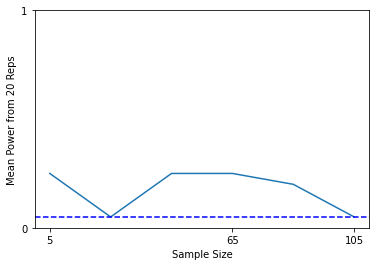

In [10]:
plot_power2()